In [19]:
import sys
import affine
import itertools
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import seaborn as sns
from skimage.filters import threshold_otsu
from skimage import exposure
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from rasterio.features import shapes
from scipy.ndimage import gaussian_filter
from shapely.geometry import shape, Point, LineString
from shapely.ops import nearest_points


def RMSE(data):
    return np.sqrt((data ** 2).mean())


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def points_along_line(line_gdf, dist=5):    

    out = [] 
    
    # create points every 30 meters along the line
    for i, distance in enumerate(range(0, int(line_gdf.length), dist)):
        point = line_gdf.interpolate(distance)
        out.append(point[0])
        
    subpixel_points = gpd.GeoDataFrame(geometry=out, crs=line_gdf.crs)
    return subpixel_points


def simulated_waterlines(synthetic_ds, agg_factor = 30, thresh_subpixel = 0, thresh_thresholded = 0, water_index='NDWI'):
    
    # Aggregate data to new resolution
    synthetic_coarse = synthetic_ds.coarsen(x=agg_factor, y=agg_factor, boundary='trim').mean()
    
    # Set up affine object for new resolution
    aggregated_affine = affine.Affine(1 * agg_factor,       # width of pixel
                                      0,                    # row rotation  
                                      0,                    # x coord of upper left corner of upper left pixel
                                      0,                    # column rotation
                                      -1 * agg_factor,      # height of pixel
                                      0)                    # y coord of upper left corner of upper left pixel

    # Compute water index on aggregate data
    if water_index == 'NDWI':
        synthetic_coarse['NDWI'] = (synthetic_coarse.green - synthetic_coarse.nir) / (synthetic_coarse.green + synthetic_coarse.nir)
    elif water_index == 'MNDWI':
        synthetic_coarse['NDWI'] = (synthetic_coarse.green - synthetic_coarse.swir1) / (synthetic_coarse.green + synthetic_coarse.swir1)
    elif water_index == 'AWEI_ns':
        synthetic_coarse['NDWI'] = (4 * (synthetic_coarse.green * 0.0001 - synthetic_coarse.swir1 * 0.0001) - (0.25 * synthetic_coarse.nir * 0.0001 + 2.75 * synthetic_coarse.swir1 * 0.0001))
    elif water_index == 'AWEI_sh':
        synthetic_coarse['NDWI'] = synthetic_coarse.blue * 0.0001 + 2.5 * synthetic_coarse.green * 0.0001 - 1.5 * (synthetic_coarse.nir * 0.0001 + synthetic_coarse.swir1 * 0.0001) - 0.25 * synthetic_coarse.swir2 * 0.0001
    else:
        print('Fail')
        
    # Extract shoreline along true land-water validation boundary
    val_shoreline_gdf = SpatialTools.contour_extract(z_values=[0.5],
                                       ds_array=synthetic_ds.land_water,
                                       ds_crs='EPSG:4326',
                                       ds_affine=affine.Affine(1, 0, 0, 0, -1, 0),
                                       output_shp=f'validation_shoreline.shp',
                                       min_vertices=2,
                                       verbose=False)

    # Extract subpixel shoreline along aggregated dataset based on water index
    subpixel_shoreline_gdf = SpatialTools.contour_extract(z_values=[thresh_subpixel],
                                                ds_array=synthetic_coarse.NDWI,
                                                ds_crs='EPSG:4326',
                                                ds_affine=aggregated_affine,
                                                output_shp=f'waterline_synthetic.shp',
                                                min_vertices=2,
                                                verbose=False)

    # Threshold to water index value
    ds_bool = (synthetic_coarse.NDWI > thresh_thresholded)

    # Polygonise and filter to keep only values = 1
    geoms = list(shapes(ds_bool.values.astype(np.int16), transform=aggregated_affine))
    geoms = [(a, b) for (a, b) in geoms if b == 1.0]
    geoms_shape = [shape(a) for (a, b) in geoms]
    data = [b for (a, b) in geoms]

    # Covert to a geodataframe of blocky waterlines
    blocky_shoreline_gdf = gpd.GeoDataFrame(data={'value': data}, geometry = geoms_shape)
    blocky_shoreline_gdf['geometry'] =  [LineString(i.coords) for i in blocky_shoreline_gdf.geometry.exterior]
    
    # Return waterlines
    return val_shoreline_gdf, subpixel_shoreline_gdf, blocky_shoreline_gdf, synthetic_coarse


def waterline_scenarios(scenarios_df, dist=5):

    output_dist_list = []

    for i, (spectra, water_index, resolution, thresh_subpixel, thresh_thresholded) in scenarios_df.iterrows():

        print('\rSpectra:', spectra, 'Index:', water_index, 'Resolution:', resolution, 
              'Threshold subpixel:', np.round(thresh_subpixel, 2), 'Threshold threshholded:', np.round(thresh_thresholded, 2), end='')

        try:    

            ############################
            # Generate spectral xarray #
            ############################

            # Create 3D array with water and land spectra
            water_3d = np.broadcast_to(np.array(spectra_scenarios[spectra]['water']), (size_x, size, 6)).T
            land_3d = np.broadcast_to(np.array(spectra_scenarios[spectra]['land']), (size_x, size, 6)).T
            spectra_array = np.where(thresh_array, water_3d, land_3d)

            # Add validation land, water distribution as extra band
            spectra_array = np.concatenate([~thresh_array[None,...], spectra_array])

            # Convert to xarray format and rename bands
            synthetic_array = xr.DataArray(spectra_array, 
                                           dims=['variable', 'y', 'x'], 
                                           coords={'x': np.arange(0, 1000, 1), 
                                                   'y': np.arange(0, -500, -1)})
            synthetic_ds = synthetic_array.to_dataset(dim='variable').rename({0: 'land_water', 1: 'blue', 2: 'green', 3: 'red', 
                                                                              4: 'nir', 5: 'swir1', 6: 'swir2'})    


            ####################
            # Model shorelines #
            ####################

            # Generate simulated shoreline based on input threshold and aggregation factor
            output_waterlines = simulated_waterlines(synthetic_ds, 
                                                     agg_factor = resolution, 
                                                     thresh_subpixel = thresh_subpixel, 
                                                     thresh_thresholded = thresh_thresholded, 
                                                     water_index = water_index)
            val_shoreline_gdf, subpixel_shoreline_gdf, blocky_shoreline_gdf, synthetic_coarse = output_waterlines

            # Compute OTSU on NDWI layer
            otsu = threshold_otsu(synthetic_coarse.NDWI.values)

            # Compute distances for subpixel
            val_shoreline_union = val_shoreline_gdf.geometry.unary_union
            subpixel_points = points_along_line(subpixel_shoreline_gdf, dist=dist)
            subpixel_points['dist_val'] = subpixel_points.apply(lambda x: x.geometry.distance(val_shoreline_union), axis=1)

            change_sign = np.where(synthetic_ds.land_water.interp(x=xr.DataArray(subpixel_points.geometry.x, dims='z'), 
                                                                  y=xr.DataArray(subpixel_points.geometry.y, dims='z')) >= 0.5, 1, -1)
            subpixel_points['change_sign'] = change_sign
            subpixel_points['dist_val'] = subpixel_points.dist_val * subpixel_points.change_sign


            # Compute differences for blocky
            output_points = points_along_line(blocky_shoreline_gdf, dist=dist)
            blocky_points = output_points[(output_points.geometry.x != output_points.geometry.x.max()) &
                                          (output_points.geometry.y != output_points.geometry.y.min()) &
                                          (output_points.geometry.x != output_points.geometry.x.min()) &
                                          (output_points.geometry.y != output_points.geometry.y.max())].copy()
            blocky_points['dist_val'] = blocky_points.apply(lambda x: x.geometry.distance(val_shoreline_union), axis=1)

            change_sign = np.where(synthetic_ds.land_water.interp(x=xr.DataArray(blocky_points.geometry.x, dims='z'),
                                                                  y=xr.DataArray(blocky_points.geometry.y, dims='z')) >= 0.5, 1, -1)
            blocky_points['change_sign'] = change_sign
            blocky_points['dist_val'] = blocky_points.dist_val * blocky_points.change_sign

            output_dist_list.append(pd.DataFrame({'spectra': spectra, 'thresh': thresh_subpixel, 'resolution': resolution, 
                                                  'water_index': water_index, 'type': 'Subpixel', 
                                                  'Error (m)': subpixel_points['dist_val'], 'otsu': otsu}))
            output_dist_list.append(pd.DataFrame({'spectra': spectra, 'thresh': thresh_thresholded, 'resolution': resolution, 
                                                  'water_index': water_index, 'type': 'Thresholded', 
                                                  'Error (m)': blocky_points['dist_val'], 'otsu': otsu}))                                   

        except:
            pass

    # Combine results into a single dataframe
    accuracy_results = pd.concat(output_dist_list)
    
    # Return dataframe
    return accuracy_results


# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('/g/data/r78/rt1527/dea-notebooks/10_Scripts')
import SpatialTools

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Example 1: rugged cliff coast

In [ ]:
size_x, size = 1000, 500

gradient_array = np.repeat(np.linspace(0, 100, size), 
                           size_x, axis=0).reshape((size, size_x))

random_array = np.random.random((size, size_x))
gaussian_array = gaussian_filter(random_array, sigma=20)
gaussian_array = exposure.rescale_intensity(gaussian_array, out_range=(0, 100))

combined_array = (gradient_array * 2 + gaussian_array * 0.5) / 2.0
thresh_array = combined_array > combined_array.mean()

cliff_curve = thresh_array
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(thresh_array)

## Example 2: smooth beach curve

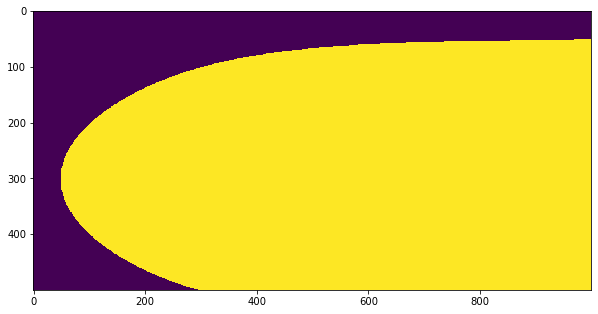

In [2]:
size, size_x = 500, 1000
empty_array = np.zeros(shape=(size, size_x))

x = np.linspace(0, size_x, 1000000)
y = (size - 250) *np.tanh(0.003 * x) ** 0.5

x2 = np.linspace(0, size_x, 1000000)
y2 = (-size + 250) *np.tanh(0.003 * x) ** 0.5

x = np.concatenate([x + 50, x2 + 50])
y = np.concatenate([y + 200, y2 + 200])

empty_array[-y.astype(int).clip(0, size - 1), 
             x.astype(int).clip(10, size_x - 1)] = 100


fig, ax = plt.subplots(figsize=(10, 10))
thresh_array = np.maximum.accumulate(empty_array.astype(int),1)
thresh_array = thresh_array==np.unique(thresh_array)[1]
thresh_array[0,:] = 0

# beach_curve = thresh_array
ax.imshow(thresh_array)


## Spectra

In [ ]:
# water_spectra = [255, 191, 101, 87, 52, 59]  # deep blue water (Stockton Beach)
# water_spectra = [709, 1028, 544, 226, 205, 180]  # shallow blue water (Stockton Beach)
water_spectra = [1952, 2113, 1110, 405, 340, 282]  # shallow/sandy bottom tropical water (GBR)
# water_spectra = [929, 1226, 1537, 1401, 248, 175]  # highly turbid water (cambridge gulf)
# water_spectra = [805, 1226, 1537, 777, 86, 68]  # mod turbid water (cambridge gulf)


# land_spectra = [2370, 3326, 4165, 4899, 6259, 5992]  # bright yellow sand, dry (Stockton Beach)
# land_spectra = [1084, 1677, 2155, 2544, 2679, 1889]  # bright yellow sand, wet (Stockton Beach)
# land_spectra = [604, 888, 1280, 1633, 1628, 1372]  # exposed cliff (Stockton Beach)
land_spectra = [670, 857, 910, 1107, 1463, 1048]  # tidal mudflat, dry (Darwin)
# land_spectra = [490, 639, 670, 756, 108, 69]  # tidal mudflat, wet (Darwin)
# land_spectra = [417, 528,  345, 2061, 712, 304]  # mangrove vegetation (Darwin)


water_spectra = [310, 262, 160, 125, 76, 60]  # deep water off Sydney
land_spectra = [1905, 2298, 2670, 3421, 3874, 3491]  # artificial (Sydney)

# water_spectra = [939,1330,1444,944,35,21]  # tidal mudflat 
# land_spectra = [733,965,1043,1088,220,126]  # tidal mudflat 


# water_spectra = [766, 950, 752, 258, 148, 122]
# land_spectra = [356, 459, 336, 1848, 598, 316]




# synthetic_ds['NDWI'] = (synthetic_ds.green - synthetic_ds.swir1) / (synthetic_ds.green + synthetic_ds.swir1)

plt.plot([490, 560, 670, 840, 1610, 2190], water_spectra, '-')
plt.plot([490, 560, 670, 840, 1610, 2190], land_spectra, '-')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance x 10000');


In [ ]:
out_perc_land = []
out_ndwi = []
out_mndwi = []
out_awei_ns = []
out_awei_sh = []
out_wi = []

for perc_land in np.arange(0, 1.0, 0.01):
    
    mean_blue = np.mean(perc_land * land_spectra[0] + (1.0 - perc_land) * water_spectra[0])
    mean_green = np.mean(perc_land * land_spectra[1] + (1.0 - perc_land) * water_spectra[1])
    mean_red = np.mean(perc_land * land_spectra[2] + (1.0 - perc_land) * water_spectra[2])
    mean_nir = np.mean(perc_land * land_spectra[3] + (1.0 - perc_land) * water_spectra[3])
    mean_swir1 = np.mean(perc_land * land_spectra[4] + (1.0 - perc_land) * water_spectra[4])
    mean_swir2 = np.mean(perc_land * land_spectra[5] + (1.0 - perc_land) * water_spectra[5])        
    
    awei_ns = (4 * (mean_green * 0.0001 - mean_swir1 * 0.0001) - (0.25 * mean_nir * 0.0001 + 2.75 * mean_swir1 * 0.0001))
    awei_sh = mean_blue * 0.0001 + 2.5 * mean_green * 0.0001 - 1.5 * (mean_nir * 0.0001 + mean_swir1 * 0.0001) - 0.25 * mean_swir2 * 0.0001
    ndwi = (mean_green - mean_nir) / (mean_green + mean_nir)
    mndwi = (mean_green - mean_swir1) / (mean_green + mean_swir1)
    wi = (1.7204 + (171 * mean_green * 0.0001) + (3 * mean_red * 0.0001) - (70 * mean_nir * 0.0001) - (45 * mean_swir1 * 0.0001) - (71 * mean_swir2 * 0.0001))/15
    
    out_perc_land.append(perc_land) 
    out_ndwi.append(ndwi) 
    out_mndwi.append(mndwi)
    out_awei_ns.append(awei_ns)
    out_awei_sh.append(awei_sh)
    out_wi.append(wi)
    
out_indices = pd.DataFrame({'Fractional pixel composition (% land)': out_perc_land, 
                            'NDWI': out_ndwi, 'MNDWI': out_mndwi, 'AWEI_ns (Feyisa et al. 2014)': out_awei_ns, 
                            'AWEI_sh (Feyisa et al. 2014)': out_awei_sh, 'WI (Fisher et al. 2016)': out_wi})

fig, axes = plt.subplots(1, 2, figsize = (16, 8))
out_indices.plot(x='Fractional pixel composition (% land)', y = 'NDWI', ax=axes[0])
out_indices.plot(x='Fractional pixel composition (% land)', y = 'MNDWI', ax=axes[0])     
out_indices.plot(x='Fractional pixel composition (% land)', y = 'AWEI_ns (Feyisa et al. 2014)', ax=axes[1])     
out_indices.plot(x='Fractional pixel composition (% land)', y = 'AWEI_sh (Feyisa et al. 2014)', ax=axes[1])    
out_indices.plot(x='Fractional pixel composition (% land)', y = 'WI (Fisher et al. 2016)', ax=axes[1])  
axes[0].axvline(0.5, color='black', linestyle='--')
axes[1].axvline(0.5, color='black', linestyle='--')
axes[0].set_title('Non-linear')
axes[1].set_title('Linear')
axes[0].set_ylabel("Index value");


In [ ]:
# Create 3D array with water and land spectra
water_3d = np.broadcast_to(np.array(water_spectra), (size_x, size, 6)).T
land_3d = np.broadcast_to(np.array(land_spectra), (size_x, size, 6)).T
spectra_array = np.where(thresh_array, water_3d, land_3d)

# Add validation land, water distribution as extra band
spectra_array = np.concatenate([~thresh_array[None,...], spectra_array])

# Convert to xarray format and rename bands
synthetic_array = xr.DataArray(spectra_array, dims=['variable', 'y', 'x'], coords={'x': np.arange(0, 1000, 1),
                                                                                   'y': np.arange(0, -500, -1)})
synthetic_ds = synthetic_array.to_dataset(dim='variable').rename({0: 'land_water', 1: 'blue', 2: 'green', 3: 'red', 
                                                                  4: 'nir', 5: 'swir1', 6: 'swir2'})

# Compute NDWI on validation dataset
# synthetic_ds['NDWI'] = (synthetic_ds.green - synthetic_ds.nir) / (synthetic_ds.green + synthetic_ds.nir)   
synthetic_ds['NDWI'] = (4 * (synthetic_ds.green * 0.0001 - synthetic_ds.swir1 * 0.0001) - (0.25 * synthetic_ds.nir * 0.0001 + 2.75 * synthetic_ds.swir1 * 0.0001))

# Extract contours
val_shoreline_gdf, subpixel_shoreline_gdf, blocky_shoreline_gdf, synthetic_coarse = simulated_waterlines(synthetic_ds, 
                                                                                                         agg_factor = 30, 
                                                                                                         thresh = -0.85,
                                                                                                         water_index='AWEI_ns')

# Plot validation and aggregated landscapes
fig, ax = plt.subplots(1, 2, figsize=(20.25, 5))
synthetic_ds.NDWI.plot(ax=ax[0], cmap=truncate_colormap(plt.get_cmap('RdYlBu'), 0.25, 0.93))
synthetic_coarse.NDWI.plot(ax=ax[1], cmap=truncate_colormap(plt.get_cmap('RdYlBu'), 0.25, 0.93))

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(22, 9))
synthetic_coarse.NDWI.plot(ax=ax, cmap=truncate_colormap(plt.get_cmap('RdYlBu'), 0.25, 0.90))
val_shoreline_gdf.plot(ax=ax, linewidth=3)
subpixel_shoreline_gdf.plot(ax=ax, color='red', linewidth=3)
blocky_shoreline_gdf.plot(ax=ax, color='black', linewidth=3)


## Analyse by threshold

In [22]:
index_scenarios = ['NDWI', 'MNDWI', 'AWEI_ns']  
thresh_subpixel_scenarios = np.linspace(-2.0, 2.0, 201)
resolution_scenarios = [30]

spectra_scenarios = {          
                     'sandy_beach': {'water': [773, 908, 74,308,264,198], 
                                     'land': [2644,3689,4307,5181,5826,5099]},    
                     
                     'artificial_shoreline': {'water': [310, 262, 160, 125, 76, 60], 
                                              'land': [1905, 2298, 2670, 3421, 3874, 3491]},   # 16-day Landsat 8, 06/12/2015, 33.96768°S, 151.19934°E
    
                     'rocky_cliff': {'water': [390, 263, 110, 116, 70, 47], 
                                     'land': [743, 965, 979, 1468, 1178, 786]},
                     
                     'tidal_mudflat': {'water': [939,1330,1444,944,35,21], 
                                       'land': [733,965,1043,1088,220,126]},   # 16-day Landsat 8, 02/08/2016, 12.66255°S, 130.59904°E
    
                     'mangrove_vegetation': {'water': [766, 950, 752, 258, 148, 122], 
                                             'land': [356, 459, 336, 1848, 598, 316]}
}


# Create dataframe of all scenarios
all_combinations = itertools.product(spectra_scenarios, index_scenarios, 
                                     resolution_scenarios, thresh_subpixel_scenarios)
scenarios_df = pd.DataFrame(all_combinations, columns=['spectra', 'water_index', 
                                                       'resolution', 'thresh_subpixel'])

# Add new column duplicating subpixel threshold for threshholded analysis
scenarios_df['thresh_thresholded'] = scenarios_df.thresh_subpixel


In [ ]:
# Analyse scenarios   
accuracy_results = waterline_scenarios(scenarios_df, dist=5)   
accuracy_results.head()


Spectra: sandy_beach Index: AWEI_ns Resolution: 30 Threshold subpixel: -1.74 Threshold threshholded: -1.74

### Plot results by threshold

/g/data/v10/public/modules/dea-env/20190522/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Text(0, 3.9, 'No valid\nwaterline\nextracted')

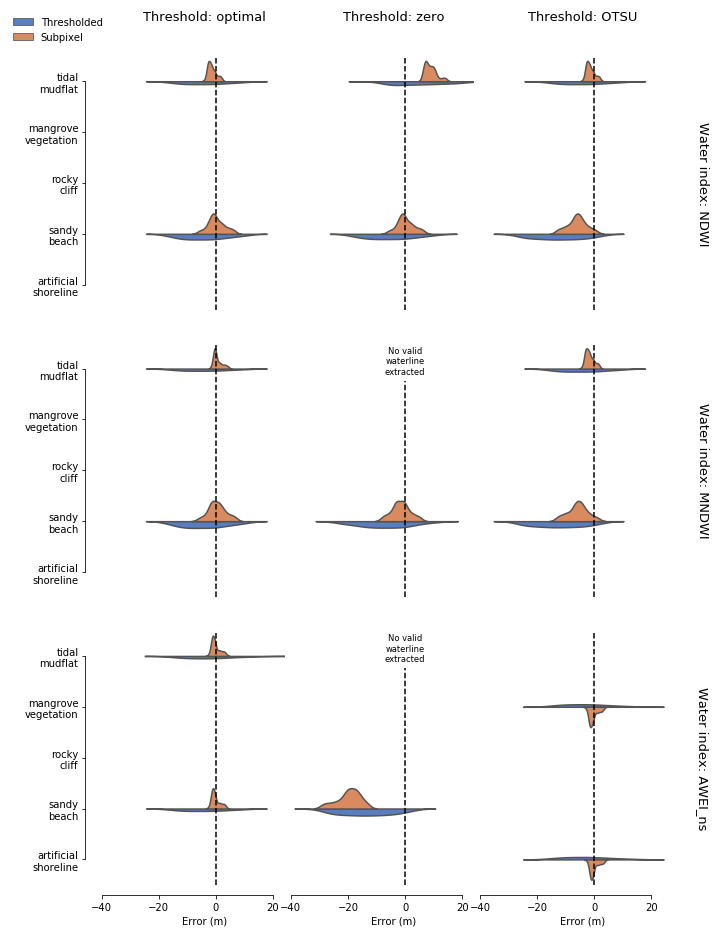

In [6]:
# Identify closest threshold to OTSU for each set of scenarios
accuracy_results['diff_otsu'] = abs(accuracy_results.thresh - accuracy_results.otsu)
is_otsu = (accuracy_results
           .groupby(['spectra', 'resolution', 'water_index', 'type'])['diff_otsu']
           .transform(min) == accuracy_results['diff_otsu'])
accuracy_results_otsu = accuracy_results[is_otsu].copy()
accuracy_results_otsu['thresh'] = 'OTSU\n'

# Identify zero threshold
accuracy_results_zero = accuracy_results[accuracy_results.thresh == 0].copy()
accuracy_results_zero['thresh'] = 'zero\n'

# Identify optimal threshold
accuracy_results['RMSE'] = accuracy_results.groupby(['spectra', 'thresh', 'resolution', 'water_index', 'type'])['Error (m)'].transform(RMSE)   
is_optimal = (accuracy_results
           .groupby(['spectra', 'resolution', 'water_index', 'type'])['RMSE']
           .transform(min) == accuracy_results['RMSE'])
accuracy_results_optimal = accuracy_results[is_optimal].copy()
accuracy_results_optimal['thresh'] = 'optimal\n'


# Merge all datasets into a single dataframe
accuracy_results_all = pd.concat([accuracy_results_optimal, accuracy_results_zero, accuracy_results_otsu])
accuracy_results_all['spectra'] = accuracy_results_all.spectra.str.replace('_', '\n')


#################
# Generate plot #
#################

# Determine nice plotting order for spectra (from lowest to highest mean)
x_order = ['artificial\nshoreline', 'sandy\nbeach',  'rocky\ncliff', 'mangrove\nvegetation', 'tidal\nmudflat']

g = sns.catplot(x="Error (m)", y="spectra", hue='type', data=accuracy_results_all, 
                col='thresh', row='water_index', height=4.2, aspect=0.8, palette="muted", 
                split=True, kind="violin", inner=None, scale='area', bw=0.33, 
                order=x_order, 
                orient='h',
                hue_order=['Thresholded', 'Subpixel'],
                col_order=['optimal\n', 'zero\n', 'OTSU\n'], 
                row_order=['NDWI', 'MNDWI', 'AWEI_ns'], 
                margin_titles=True)




##################
# Customise plot #
##################

# # Set up named axes
(ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)  = g.axes

# # Bulk add horizontal 0 error line to all plots
[ax.axvline(0, color='black', linestyle='--') for ax in g.axes.flat]

# # Remove axis labels from bottom facets
ax1.set_ylabel('')
ax4.set_ylabel('')
ax7.set_ylabel('')

# # Move facet titles to right and top of panels, and hide existing labels
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(row_template = 'Water index: {row_name}', col_template = 'Threshold: {col_name}\n', size=13)

# # Use nicer offset and trimmed axes
sns.despine(offset=10, trim=True)

# Remove axes lines and tickes from top facets
sns.despine(ax=ax1, bottom=True)
sns.despine(ax=ax2, left=True, bottom=True)
sns.despine(ax=ax3, left=True, bottom=True)
ax1.tick_params(axis='x', which='both',length=0)
ax2.tick_params(axis='both', which='both',length=0)
ax3.tick_params(axis='both', which='both',length=0)

# Remove axes lines and tickes from middle facets
sns.despine(ax=ax4, bottom=True)
sns.despine(ax=ax5, left=True, bottom=True)
sns.despine(ax=ax6, left=True, bottom=True)
ax4.tick_params(axis='x', which='both',length=0)
ax5.tick_params(axis='both', which='both',length=0)
ax6.tick_params(axis='both', which='both',length=0)

# Remove axes lines and tickes from bottom facets
sns.despine(ax=ax8, left=True)
sns.despine(ax=ax9, left=True)
ax8.tick_params(axis='y', which='both',length=0)
ax9.tick_params(axis='y', which='both',length=0)

# # Add extra white space between columns
plt.subplots_adjust(hspace=0.13, wspace=-0.13)

# Make legend have two columns, and move to custom position
handles, labels = g.axes[0][0].get_legend_handles_labels()
g._legend.remove()
g.fig.legend(handles, labels, ncol=1, loc='upper center', 
                bbox_to_anchor=(0.07, 1.02), frameon=False)

# Add annotation for missing MNDWI data
ax5.text(0, 3.9, "No valid\nwaterline\nextracted", horizontalalignment='center', size='small', 
         color='black', bbox=dict(facecolor='white', edgecolor='white', alpha=1.0))
ax8.text(0, 3.9, "No valid\nwaterline\nextracted", horizontalalignment='center', size='small', 
         color='black', bbox=dict(facecolor='white', edgecolor='white', alpha=1.0))


## Analyse by resolution

In [20]:
scenarios_df = (accuracy_results
 
                 # Keep only rows with optimal thresholds
                 .loc[is_optimal, ['spectra', 'thresh', 'resolution', 'water_index', 'type']]
                 .drop_duplicates()

                 # Spread into wide format
                 .reset_index(drop=True)
                 .set_index(['spectra', 'resolution', 'water_index', 'type'], append=True) 
                 .unstack('type')

                 # Collapse NA rows by taking max of groups
                 .groupby(['spectra', 'resolution', 'water_index'])
                 .max()

                 # Remove redundant multiindex levels 
                 .xs('thresh', axis=1, drop_level=True)
                 .reset_index()

                 # Rename and reorder columns
                 .rename({'Subpixel': 'thresh_subpixel',
                          'Thresholded': 'thresh_thresholded'}, axis=1) 
                 .iloc[:, [0, 2, 1, 3, 4]])

# Create resolution scenarios
resolution_scenarios = [1, 2, 3, 5, 10, 15, 20, 25, 30]
scenarios_df = scenarios_df.loc[scenarios_df.index.repeat(len(resolution_scenarios))]
scenarios_df['resolution'] = resolution_scenarios * int(scenarios_df.shape[0] / len(resolution_scenarios))
scenarios_df.shape

# Analyse scenarios 
accuracy_results_res = waterline_scenarios(scenarios_df, dist=5)   
accuracy_results_res.head()



Spectra: tidal_mudflat Index: NDWI Resolution: 30 Threshold subpixel: 0.06 Threshold threshholded: 0.06

,spectra,thresh,resolution,water_index,type,Error (m),otsu
0,sandy_beach,-1.28,1,AWEI_ns,Subpixel,-0.019294,-2.581077
1,sandy_beach,-1.28,1,AWEI_ns,Subpixel,0.027286,-2.581077
2,sandy_beach,-1.28,1,AWEI_ns,Subpixel,0.027286,-2.581077
3,sandy_beach,-1.28,1,AWEI_ns,Subpixel,-0.019294,-2.581077
4,sandy_beach,-1.28,1,AWEI_ns,Subpixel,0.027286,-2.581077


### Plot results by resolution

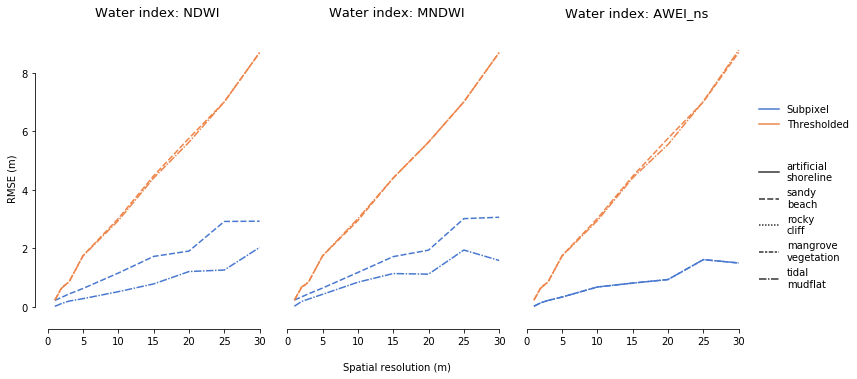

In [21]:

test = pd.DataFrame(accuracy_results_res.groupby(['spectra', 'thresh', 'resolution', 'water_index', 'type'])['Error (m)'].apply(RMSE)).reset_index()
test['spectra'] = test.spectra.str.replace('_', '\n')
test = test.rename({'resolution': '\nSpatial resolution (m)'}, axis=1)
test = test.rename({'Error (m)': 'RMSE (m)'}, axis=1)

# test = pd.DataFrame(accuracy_results_res.groupby(['spectra', 'thresh', 'resolution', 'water_index', 'type'])['Error (m)'].mean()).reset_index()
# test['spectra'] = test.spectra.str.replace('_', '\n')
# test = test.rename({'resolution': '\nSpatial resolution (m)'}, axis=1)
# test = test.rename({'Error (m)': 'RMSE (m)'}, axis=1)

# Plot data
g = sns.relplot(x="\nSpatial resolution (m)", 
                y="RMSE (m)", 
                hue='type', 
                col='water_index', 
                style='spectra',
                data=test, 
                col_order=['NDWI', 'MNDWI', 'AWEI_ns'],
                style_order = x_order, 
                height=5.0, 
                aspect=0.7, 
                palette="muted", 
                kind='line')

# Set up named axes
(ax1, ax2, ax3) = g.axes[0]

# Remove axis labels from bottom facets
ax1.set_xlabel('')
ax3.set_xlabel('')

# Move facet titles to right and top of panels, and hide existing labels
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(col_template = 'Water index: {col_name}\n', size=13)

# Remove legend titles
g._legend.texts[0].set_text("")
g._legend.texts[3].set_text("\n")
g._legend.set_title("")

# Use nicer offset and trimmed axes
sns.despine(offset=10, trim=True)
sns.despine(ax=ax2, left=True)
sns.despine(ax=ax3, left=True)
ax2.tick_params(axis='y', which='both',length=0)
ax3.tick_params(axis='y', which='both',length=0)
